In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdForceFieldHelpers import UFFGetMoleculeForceField
import pandas as pd
import numpy as np

from utils.converters import convert_xyz_to_mol


def optimize_conformer(mol, conf_id):
    """Optimize the geometry of a specific conformer."""
    ff = UFFGetMoleculeForceField(mol, confId=conf_id)
    ff.Minimize()
    return ff.CalcEnergy()


def add_and_optimize_conformers(mol, N, duplicate=True, perturb_scale=0.3):
    """Generate N conformers, optimize them, and return the average energy."""
    energies = [0]
    energies[0] = UFFGetMoleculeForceField(mol, confId=0).CalcEnergy()

    rmsds = []

    if not duplicate:
        AllChem.EmbedMultipleConfs(mol, numConfs=N, randomSeed=42)
    else:
        ref_conf = mol.GetConformer(0)
        # Get the positions from the reference conformer
        positions = ref_conf.GetPositions()
        # Create new conformers
        for i in range(N):
            # Create a new conformer
            new_conf = Chem.Conformer(mol.GetNumAtoms())

            if perturb_scale > 0:
                noise = np.random.normal(0, perturb_scale, positions.shape)
                positions += noise

            # Set the 3D positions from the reference conformer
            for j in range(mol.GetNumAtoms()):
                new_conf.SetAtomPosition(j, positions[j])
            # Add it to the molecule
            mol.AddConformer(new_conf, assignId=True)

    for conf_id in range(1, mol.GetNumConformers()):
        energy = optimize_conformer(mol, conf_id)
        energies.append(energy)
        rmsds.append(AllChem.GetConformerRMS(mol, 0, conf_id))

    df = pd.DataFrame({"energies": energies[1:], "rmsds": rmsds})
    # soft by rmsds
    df = df.sort_values("rmsds")

    # Compute the average energy of all N conformers (excluding the initial one)
    avg_energy_N_conformers = (
        sum(energies[1:]) / N
    )  # Exclude the initial conformer (index 0)

    # Return initial conformer energy and average energy of N conformers
    return energies[0], avg_energy_N_conformers, df


mol = convert_xyz_to_mol("/auto/home/davit/3DMolGen/tests/fixtures/aspirin.xyz")
mol = convert_xyz_to_mol(
    "/auto/home/davit/3DMolGen/tests/fixtures/dsgdb9nsd_000087.xyz"
)

# mol = Chem.SDMolSupplier("./data/conf.sdf")[0]
# print("EN: ", mol.GetProp("ENERGY"))

N = 25  # Number of additional conformers to generate
initial_energy, avg_energy_N_conformers, df = add_and_optimize_conformers(
    mol, N, duplicate=False, perturb_scale=0.3
)

print(f"Initial conformer energy: {initial_energy:.4f} kcal/mol")
print(f"Average energy of {N} conformers: {avg_energy_N_conformers:.4f} kcal/mol")

Initial conformer energy: 343.9519 kcal/mol
Average energy of 25 conformers: 326.1694 kcal/mol


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the energy distribution of the generated conformers
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.histplot(df["energies"], bins=30, kde=True)
plt.xlabel("Energy (kcal/mol)")
plt.legend()

# Line plot of RMSD vs. energy
plt.subplot(1, 2, 2)
plt.scatter(df["rmsds"], df["energies"], marker="o")
plt.xlabel("RMSD")
plt.ylabel("Energy (kcal/mol)")

plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
from rdkit import Chem


from evaluation.conformer import calculate_rmsd, get_conformer_statistics
from utils.converters import convert_xyz_to_sdf


mol_path = "tests/fixtures/dsgdb9nsd_000087.xyz"
output_path = "./data/out.sdf"

convert_xyz_to_sdf(mol_path, output_path)

for mol in Chem.SDMolSupplier(output_path):
    pass

Chem.MolToSmiles(mol)

# Fluctuate one of the atoms
c = mol.GetConformer(0)
initial_pos = c.GetAtomPosition(0)

initial_pos.x += 0.1
initial_pos.y += 0.1
initial_pos.z += 0.1

c.SetAtomPosition(0, [initial_pos.x, initial_pos.y, initial_pos.z])

for gt_mol in Chem.SDMolSupplier(output_path):
    pass

print("RMSD: ", calculate_rmsd(mol, gt_mol))

res = get_conformer_statistics(mol, gt_mol)
res["resuts"]["bond_lengths"].iloc[0]

RMSD:  0.07745966692414837


np.True_

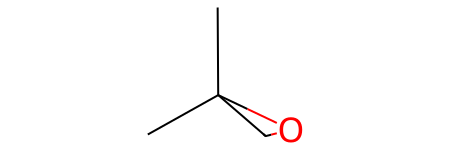

In [ ]:
from rdkit import Chem

m = list(Chem.SDMolSupplier("./data/out.sdf"))[0]

In [ ]:
print(res["resuts"][""].iloc[0])  # Index denotes molecule

nan


In [1]:
from rdkit import Chem

path = "/auto/home/davit/3DMolGen/data/debug_icm_out_oo.sdf"

m = list(Chem.SDMolSupplier(path))[0]

Chem.MolToSmiles(m) == "Cc1ccc([C@H]2[CH]c3cnccc3[N]C2=O)cc1"

[18:46:01] Explicit valence for atom # 13 N greater than permitted
[18:46:01] ERROR: Could not sanitize molecule ending on line 213
[18:46:01] ERROR: Explicit valence for atom # 13 N greater than permitted


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

def partition_sdf_range(input_file_path, output_file_path, start_index, end_index):
    """
    Partition a specific range of molecules from an input SDF file to a new output SDF file.
    
    Parameters:
    -----------
    input_file_path : str
        Path to the input SDF file
    output_file_path : str
        Path to the output SDF file
    start_index : int
        Starting molecule index (0-based)
    end_index : int
        Ending molecule index (exclusive)
    
    Returns:
    --------
    int
        Number of molecules written to the output file
    """
    # Validate input
    if start_index < 0 or end_index < start_index:
        raise ValueError("Invalid range. start_index must be non-negative and less than end_index.")
    
    # Open the input SDF file
    input_suppl = Chem.SDMolSupplier(input_file_path)
    
    # Open the output SDF file
    writer = Chem.SDWriter(output_file_path)
    
    # Counter for molecules written
    molecules_written = 0
    
    # Iterate through the input file
    for idx, mol in enumerate(input_suppl):
        # Skip molecules before the start index
        if idx < start_index:
            continue
        
        # Stop if we've reached the end index
        if idx >= end_index:
            break
        
        # Write the molecule to the output file
        if mol is not None:
            writer.write(mol)
            molecules_written += 1
    
    # Close the writer
    writer.close()
    
    return molecules_written

In [3]:
partition_sdf_range("./data/pcqm4m-v2-train.sdf", "./data/pcqm4m-v2-train_gg.sdf", 84999, 85001)

[00:54:50] Both bonds on one end of an atropisomer are on the same side - atoms are: 0 1
[00:54:50] The 2 defining bonds for an atropisomer are co-planar - atoms are: 6 5
[00:54:51] Both bonds on one end of an atropisomer are on the same side - atoms are: 6 2
[00:54:55] Both bonds on one end of an atropisomer are on the same side - atoms are: 6 10
[00:54:56] The 2 defining bonds for an atropisomer are co-planar - atoms are: 14 9
[00:54:56] The 2 defining bonds for an atropisomer are co-planar - atoms are: 0 9
[00:54:56] Both bonds on one end of an atropisomer are on the same side - atoms are: 1 3
[00:54:56] Both bonds on one end of an atropisomer are on the same side - atoms are: 9 5
[00:54:56] The 2 defining bonds for an atropisomer are co-planar - atoms are: 10 9
[00:54:56] The 2 defining bonds for an atropisomer are co-planar - atoms are: 10 9
[00:54:56] Both bonds on one end of an atropisomer are on the same side - atoms are: 9 5
[00:54:56] Both bonds on one end of an atropisomer a

2

wget http://ogb-data.stanford.edu/data/lsc/pcqm4m-v2-train.sdf.tar.gz
unzip pcqm4m-v2-train.sdf.tar.gz

/path/.../icm-3.9-4/icm -vls _gingerH.icm ./data/pcqm4m-v2-train.sdf ./data/pcqm4m-v2-train-ginger-full.sdf


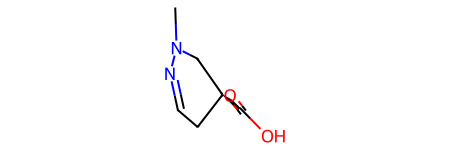

In [9]:
SDMolSupplier("data/pcqm4m-v2-train.sdf")[3000000]

In [ ]:
import rdkit
from tqdm import tqdm

from rdkit.Chem import AllChem, Draw, SDMolSupplier, MolToSmiles, SDWriter, Mol

writer = SDWriter("data/eval/tt.sdf")

N = 10
i = 0
for mol in tqdm(SDMolSupplier("data/pcqm4m-v2-train.sdf")):
    mol: Mol = mol
    print(MolToSmiles(mol))
    mol.SetIntProp("mol_id", i)

    mol.RemoveAllConformers()

    i+=1

    writer.write(mol)
    if i >= N:
        break

  0%|          | 9/3378606 [00:00<23:30, 2394.62it/s]

Cc1ccc([C@H]2[CH]c3cnccc3[N]C2=O)cc1
COc1ccc(/C=C/N(C)C(C)=O)c(OC)c1
C=CCN(/C=C/c1ccccc1C)C(C)=O
C=CCN(/C=C/c1ccccc1F)C(C)=O
C=CCN(/C=C/c1ccccc1Cl)C(C)=O
CCN(/C=C/c1ccccc1Cl)C(C)=O
COC(=O)CC[C@H]1O[C@H](OC)[C@H](O)[C@@H]1O
CN[C@@H](S)N/N=C(/C)c1ccccn1
C/C(=N/N[C@@H](N)S)c1ccccn1
NC1=CC(=O)C=C[C]1C1=N[N]C(=S)N1N


In [ ]:
from rdkit import Chem
import pandas as pd
import os

def sdf_to_dataframe_with_3d_sdfs(input_sdf, sdf_output_dir):
    # Ensure the output directory exists
    if not os.path.exists(sdf_output_dir):
        os.makedirs(sdf_output_dir)

    # Load the SDF file
    suppl = Chem.SDMolSupplier(input_sdf)
    data = []

    for idx, mol in enumerate(suppl):
        if mol is None:
            continue  # Skip invalid molecules

        # Get molecule properties
        props = mol.GetPropsAsDict()

        # Add SMILES and canonical SMILES
        smiles = Chem.MolToSmiles(mol)
        canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
        props['SMILES'] = smiles
        props['Canonical_SMILES'] = canonical_smiles

        # Save the molecule's 3D conformation to a separate SDF file
        sdf_filename = os.path.join(sdf_output_dir, f"molecule_{idx}.sdf")
        writer = Chem.SDWriter(sdf_filename)
        writer.write(mol)
        writer.close()
        props['3D_SDF_File'] = sdf_filename

        # Append the properties to the data list
        data.append(props)

    # Convert the data list to a pandas DataFrame
    df = pd.DataFrame(data)
    return df

# Input and output paths
input_sdf = 'input.sdf'  # Replace with your input SDF file
output_sdf_dir = 'molecule_sdfs'  # Replace with your desired output directory for 3D SDF files
output_csv = 'molecules.csv'  # Replace with your desired CSV file path

# Process the SDF file and create the DataFrame
df = sdf_to_dataframe_with_3d_sdfs(input_sdf, output_sdf_dir)

# Save the DataFrame to a CSV file
df.to_csv(output_csv, index=False)

print(f"Processed {len(df)} molecules. Data saved to {output_csv} and SDF files in {output_sdf_dir}.")


In [13]:
import rdkit
from tqdm import tqdm
from copy import deepcopy

from rdkit.Chem import AllChem, Draw, SDMolSupplier, MolToSmiles, SDWriter, Mol

writer = SDWriter("ncf.sdf")
writer2 = SDWriter("cf.sdf")

N = 10
i = 0
for mol in tqdm(SDMolSupplier("data/pcqm4m-v2-train.sdf")):
    mol: Mol = mol

    mol2 = deepcopy(mol)
    print(MolToSmiles(mol) == MolToSmiles(mol2))
    print(mol.GetPropsAsDict(includePrivate=True, includeComputed=True))
    mol2.RemoveAllConformers()

    writer.write(mol)
    writer2.write(mol2)

    i+=1
    break

writer.close()
writer2.close()

  0%|          | 0/3378606 [00:00<?, ?it/s]

True
{'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x786ed03e6140>, '_Name': '/Volumes/PubChemQCDataBaseWork/pubchemqc2017database/xyz/00000000_00009999/0.xyz', '_MolFileInfo': ' OpenBabel02162213453D', '_MolFileComments': '', '_MolFileChiralFlag': 1, 'numArom': 2, '_StereochemDone': 1, '_smilesAtomOutputOrder': <rdkit.rdBase._vectj object at 0x786ed03e6340>, '_smilesBondOutputOrder': <rdkit.rdBase._vectj object at 0x786ed03e47c0>}


In [27]:
import rdkit
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, SDMolSupplier, MolToSmiles, SDWriter, Mol
from tqdm import tqdm

from utils.sdf_to_csv import SDFToCSVParser
from evaluation.conformer import  calculate_rmsd_matrix, get_conformer_statistics


In [1]:
df1 = SDFToCSVParser("/auto/home/davit/3DMolGen/data/eval/output_censo.sdf", "data/join").parse(index_col="pickle_path")
df2 = SDFToCSVParser("/auto/home/davit/3DMolGen/data/eval/output_censo_ginger.sdf", "data/join").parse(index_col="pickle_path")
df3 = SDFToCSVParser("/auto/home/davit/3DMolGen/data/eval/output_censo_rdkit.sdf", "data/join").parse(index_col="pickle_path")

NameError: name 'SDFToCSVParser' is not defined

In [29]:
df3

,_index,smi,mol_id,datasets,bace,charge,temperature,totalconfs,uniqueconfs,ensembleGsolv,...,ensembleGmRRHO,ensemblefreeenergy,poplowestpct,lowestenergy,lowestfreeenergy,lowestGsolv,conf_path,pdbbind,lipo,clintox
pickle_path,,,,,,,,,,,,,,,,,,,,,
rd_mols/NBTCNBCWVKBTIT-PECIQRARNA-N.pickle,0,COc1ccc([C@@]2(c3cccc(-c4cccnc4)c3)N=C(N)N(C)C...,rd_mols/NBTCNBCWVKBTIT-PECIQRARNA-N.pickle,['bace'],{'class': 1.0},0.0,298.15,5.0,5.0,0.0,...,0.304611,0.149598,26.22,-1679.212070,-1678.907499,0.0,data/join/_output_censo_rdkit_copy_confs/1.sdf,NaN,NaN,NaN
rd_mols/WYAJCDWGUPQGAC-RHRRZNHENA-O.pickle,1,CC(=O)N[C@@H](Cc1cc(F)cc(F)c1)[C@H](O)C[NH2+][...,rd_mols/WYAJCDWGUPQGAC-RHRRZNHENA-O.pickle,['bace'],{'class': 0.0},1.0,298.15,10.0,10.0,0.0,...,0.469157,0.522527,48.02,-1653.389814,-1652.920435,0.0,data/join/_output_censo_rdkit_copy_confs/2.sdf,NaN,NaN,NaN
rd_mols/WHCBVAPBSFXPHD-HUCVSMBFNA-N.pickle,2,Cc1ccccc1-c1ccc2nc(N)c(CCC(=O)NCC3CCCCC3)cc2c1,rd_mols/WHCBVAPBSFXPHD-HUCVSMBFNA-N.pickle,['bace'],{'class': 1.0},0.0,298.15,35.0,35.0,0.0,...,0.455810,0.660955,14.82,-1248.734177,-1248.278471,0.0,data/join/_output_censo_rdkit_copy_confs/3.sdf,NaN,NaN,NaN
rd_mols/WCVRLSCSQDAERN-SJTVKYBFNA-O.pickle,3,CN(c1cc(C(=O)N[C@@H](Cc2ccccc2)[C@H](O)C[NH2+]...,rd_mols/WCVRLSCSQDAERN-SJTVKYBFNA-O.pickle,['bace'],{'class': 1.0},1.0,298.15,34.0,34.0,0.0,...,0.506355,0.645832,12.57,-2063.614738,-2063.108111,0.0,data/join/_output_censo_rdkit_copy_confs/4.sdf,NaN,NaN,NaN
rd_mols/MLDNPVIFXVSEGX-VVJCJFQINA-O.pickle,4,COc1ccc([C@@]2(c3cccc(-c4cncnc4)c3)CCC(N)=[NH+...,rd_mols/MLDNPVIFXVSEGX-VVJCJFQINA-O.pickle,['bace'],{'class': 0.0},1.0,298.15,15.0,15.0,0.0,...,0.322757,0.343624,12.75,-1106.752743,-1106.430066,0.0,data/join/_output_censo_rdkit_copy_confs/5.sdf,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rd_mols/GZARJCKECXNHAL-TWSYTRIPNA-N.pickle,257,COc1ccc(-c2cccc([C@H]3C[C@@H]3[C@]3(C)CC(=O)N(...,rd_mols/GZARJCKECXNHAL-TWSYTRIPNA-N.pickle,['bace'],{'class': 0.0},0.0,298.15,36.0,36.0,0.0,...,0.367042,0.574610,12.52,-1167.869995,-1167.503048,0.0,data/join/_output_censo_rdkit_copy_confs/258.sdf,NaN,NaN,NaN
rd_mols/TWHSRVVFCICXII-TZLZNYSSNA-O.pickle,258,CC#Cc1cncc(-c2cccc([C@]3(C4CC4)N=C(C)C(N)=[NH+...,rd_mols/TWHSRVVFCICXII-TZLZNYSSNA-O.pickle,['bace'],{'class': 1.0},1.0,298.15,23.0,23.0,0.0,...,0.312492,0.497426,11.33,-1031.442914,-1031.130697,0.0,data/join/_output_censo_rdkit_copy_confs/259.sdf,NaN,NaN,NaN
rd_mols/DYAVMDXKNKDORY-NCIJNWKXNA-O.pickle,259,CC[C@@H](C)[C@]1(NC(C)=O)CCN([C@@H](CCc2ccccc2...,rd_mols/DYAVMDXKNKDORY-NCIJNWKXNA-O.pickle,['bace'],{'class': 0.0},1.0,298.15,10.0,10.0,0.0,...,0.708784,0.607805,40.86,-2270.747419,-2270.038433,0.0,data/join/_output_censo_rdkit_copy_confs/260.sdf,NaN,NaN,NaN


In [31]:
def evaluate_results_table(df1: pd.DataFrame, df2: pd.DataFrame, index_col: str = "_index", r_suffix: str = "_ging"):
    # Do left join on the index column
    merged = df1.join(df2, on=index_col, rsuffix=r_suffix)
    
    print("Missing molecules", merged[f'_index{r_suffix}'].isna().sum())
    print("--------\n")
    print("Mean number of G.T. conformers", merged['uniqueconfs'].describe())
    print("--------\n")
    print("Ginger NCF", merged['ncf'].describe())
    print("--------\n")
    print("Ginger nGoodConfs", merged['nGoodConfs'].describe())
    print("--------\n")

    merged = merged.dropna(subset=['ncf'])

    print("Smiles match: ", (merged['smi'] == merged[f'smi{r_suffix}']).sum())

    return merged


def evaluate_results_table_rd(df1: pd.DataFrame, df2: pd.DataFrame, index_col: str = "_index", r_suffix: str = "_ging"):
    # Do left join on the index column
    merged = df1.join(df2, on=index_col, rsuffix=r_suffix)
    
    print("Missing molecules", merged[f'_index{r_suffix}'].isna().sum())
    print("--------\n")
    print("Mean number of G.T. conformers", merged['uniqueconfs'].describe())
    print("--------\n")

    merged = merged.dropna(subset=[f'smi{r_suffix}'])

    print("Smiles match: ", (merged['smi'] == merged[f'smi{r_suffix}']).sum())

    return merged

In [32]:
merged = evaluate_results_table(df1, df2, index_col="pickle_path")

merged_rdkit = evaluate_results_table_rd(df1, df3, index_col="pickle_path", r_suffix="_rdkit")

Missing molecules 47
--------

Mean number of G.T. conformers count    534.000000
mean      16.378277
std       15.101010
min        1.000000
25%        6.000000
50%       12.000000
75%       22.000000
max      114.000000
Name: uniqueconfs, dtype: float64
--------

Ginger NCF count    487.000000
mean      17.232033
std        9.244594
min        1.000000
25%       10.000000
50%       16.000000
75%       26.000000
max       30.000000
Name: ncf, dtype: float64
--------

Ginger nGoodConfs count    487.000000
mean      44.611910
std       16.751245
min        0.000000
25%       35.000000
50%       50.000000
75%       59.000000
max       60.000000
Name: nGoodConfs, dtype: float64
--------

Smiles match:  244
Missing molecules 273
--------

Mean number of G.T. conformers count    534.000000
mean      16.378277
std       15.101010
min        1.000000
25%        6.000000
50%       12.000000
75%       22.000000
max      114.000000
Name: uniqueconfs, dtype: float64
--------

Smiles match:  133


In [33]:
merged_rdkit

,_index,smi,mol_id,datasets,bace,charge,temperature,totalconfs,uniqueconfs,ensembleGsolv,...,ensembleGmRRHO_rdkit,ensemblefreeenergy_rdkit,poplowestpct_rdkit,lowestenergy_rdkit,lowestfreeenergy_rdkit,lowestGsolv_rdkit,conf_path_rdkit,pdbbind_rdkit,lipo_rdkit,clintox_rdkit
pickle_path,,,,,,,,,,,,,,,,,,,,,
rd_mols/NBTCNBCWVKBTIT-PECIQRARNA-N.pickle,0,COc1ccc([C@@]2(c3cccc(-c4cccnc4)c3)N=C(N)N(C)C...,rd_mols/NBTCNBCWVKBTIT-PECIQRARNA-N.pickle,['bace'],{'class': 1.0},0,298.15,5,5,0.0,...,0.304611,0.149598,26.22,-1679.212070,-1678.907499,0.0,data/join/_output_censo_rdkit_copy_confs/1.sdf,NaN,NaN,NaN
rd_mols/WYAJCDWGUPQGAC-RHRRZNHENA-O.pickle,1,CC(=O)N[C@@H](Cc1cc(F)cc(F)c1)[C@@H](O)C[NH2+]...,rd_mols/WYAJCDWGUPQGAC-RHRRZNHENA-O.pickle,['bace'],{'class': 0.0},1,298.15,10,10,0.0,...,0.469157,0.522527,48.02,-1653.389814,-1652.920435,0.0,data/join/_output_censo_rdkit_copy_confs/2.sdf,NaN,NaN,NaN
rd_mols/WHCBVAPBSFXPHD-HUCVSMBFNA-N.pickle,2,Cc1ccccc1-c1ccc2nc(N)c(CCC(=O)NCC3CCCCC3)cc2c1,rd_mols/WHCBVAPBSFXPHD-HUCVSMBFNA-N.pickle,['bace'],{'class': 1.0},0,298.15,35,35,0.0,...,0.455810,0.660955,14.82,-1248.734177,-1248.278471,0.0,data/join/_output_censo_rdkit_copy_confs/3.sdf,NaN,NaN,NaN
rd_mols/WCVRLSCSQDAERN-SJTVKYBFNA-O.pickle,3,CN(c1cc(C(=O)N[C@@H](Cc2ccccc2)[C@H](O)C[NH2+]...,rd_mols/WCVRLSCSQDAERN-SJTVKYBFNA-O.pickle,['bace'],{'class': 1.0},1,298.15,34,34,0.0,...,0.506355,0.645832,12.57,-2063.614738,-2063.108111,0.0,data/join/_output_censo_rdkit_copy_confs/4.sdf,NaN,NaN,NaN
rd_mols/MLDNPVIFXVSEGX-VVJCJFQINA-O.pickle,4,COc1ccc([C@@]2(c3cccc(-c4cncnc4)c3)CCC(N)=[NH+...,rd_mols/MLDNPVIFXVSEGX-VVJCJFQINA-O.pickle,['bace'],{'class': 0.0},1,298.15,15,15,0.0,...,0.322757,0.343624,12.75,-1106.752743,-1106.430066,0.0,data/join/_output_censo_rdkit_copy_confs/5.sdf,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rd_mols/JYNDAPHZRSRSGI-XADZBWGCNA-O.pickle,256,CCCN1C(=O)OC[C@@H]1Cc1cc(C[C@@H]2CS(=O)(=O)C[C...,rd_mols/JYNDAPHZRSRSGI-XADZBWGCNA-O.pickle,['bace'],{'class': 0.0},1,298.15,19,19,0.0,...,0.590664,0.535767,19.44,-2088.363866,-2087.773048,0.0,data/join/_output_censo_rdkit_copy_confs/257.sdf,NaN,NaN,NaN
rd_mols/GZARJCKECXNHAL-TWSYTRIPNA-N.pickle,257,COc1ccc(-c2cccc([C@@H]3C[C@H]3[C@@]3(C)CC(=O)N...,rd_mols/GZARJCKECXNHAL-TWSYTRIPNA-N.pickle,['bace'],{'class': 0.0},0,298.15,36,36,0.0,...,0.367042,0.574610,12.52,-1167.869995,-1167.503048,0.0,data/join/_output_censo_rdkit_copy_confs/258.sdf,NaN,NaN,NaN
rd_mols/TWHSRVVFCICXII-TZLZNYSSNA-O.pickle,258,CC#Cc1cncc(-c2cccc([C@]3(C4CC4)N=C(C)C(N)=[NH+...,rd_mols/TWHSRVVFCICXII-TZLZNYSSNA-O.pickle,['bace'],{'class': 1.0},1,298.15,23,23,0.0,...,0.312492,0.497426,11.33,-1031.442914,-1031.130697,0.0,data/join/_output_censo_rdkit_copy_confs/259.sdf,NaN,NaN,NaN


In [35]:
posebusters_resuls_rd = []
all_rmsds_rd = []
min_rmsds_rd = []
mean_rmsds_per_conformer_rd = []
min_rmsds_per_conformer_rd = []

for i, row in tqdm(merged_rdkit.iterrows()):
    gt_mol = SDMolSupplier(row["conf_path"])[0]
    ginger_mol = SDMolSupplier(row["conf_path_rdkit"])[0]

    res = get_conformer_statistics(ginger_mol)
    posebusters_resuls_rd.append(res['results'])
    rmsd_matrix = calculate_rmsd_matrix(gt_mol, ginger_mol)

    mean_rmsds_per_conformer_rd.append(rmsd_matrix.mean(axis=1))
    min_rmsds_per_conformer_rd.append(rmsd_matrix.min(axis=1))
    min_rmsds_rd.append(rmsd_matrix.min())
    all_rmsds_rd.extend(rmsd_matrix.flatten())

261it [01:48,  2.40it/s]


In [34]:
posebusters_resuls = []
all_rmsds = []
min_rmsds = []
mean_rmsds_per_conformer = []
min_rmsds_per_conformer = []

for i, row in tqdm(merged.iterrows()):
    gt_mol = SDMolSupplier(row["conf_path"])[0]
    ginger_mol = SDMolSupplier(row["conf_path_ging"])[0]

    res = get_conformer_statistics(ginger_mol)
    posebusters_resuls.append(res['results'])
    rmsd_matrix = calculate_rmsd_matrix(gt_mol, ginger_mol)

    mean_rmsds_per_conformer.append(rmsd_matrix.mean(axis=1))
    min_rmsds_per_conformer.append(rmsd_matrix.min(axis=1))
    min_rmsds.append(rmsd_matrix.min())
    all_rmsds.extend(rmsd_matrix.flatten())



487it [00:43, 11.10it/s]


In [36]:
final = pd.concat(posebusters_resuls)
# Get only columns that have bool dtype
final_bool = final.select_dtypes(include=['bool'])

final_bool.mean()

mol_pred_loaded           1.0
sanitization              1.0
inchi_convertible         1.0
all_atoms_connected       1.0
bond_lengths              1.0
bond_angles               1.0
internal_steric_clash     1.0
aromatic_ring_flatness    1.0
double_bond_flatness      1.0
internal_energy           1.0
mol_true_loaded           0.0
mol_cond_loaded           0.0
passes_valence_checks     1.0
passes_kekulization       1.0
dtype: float64

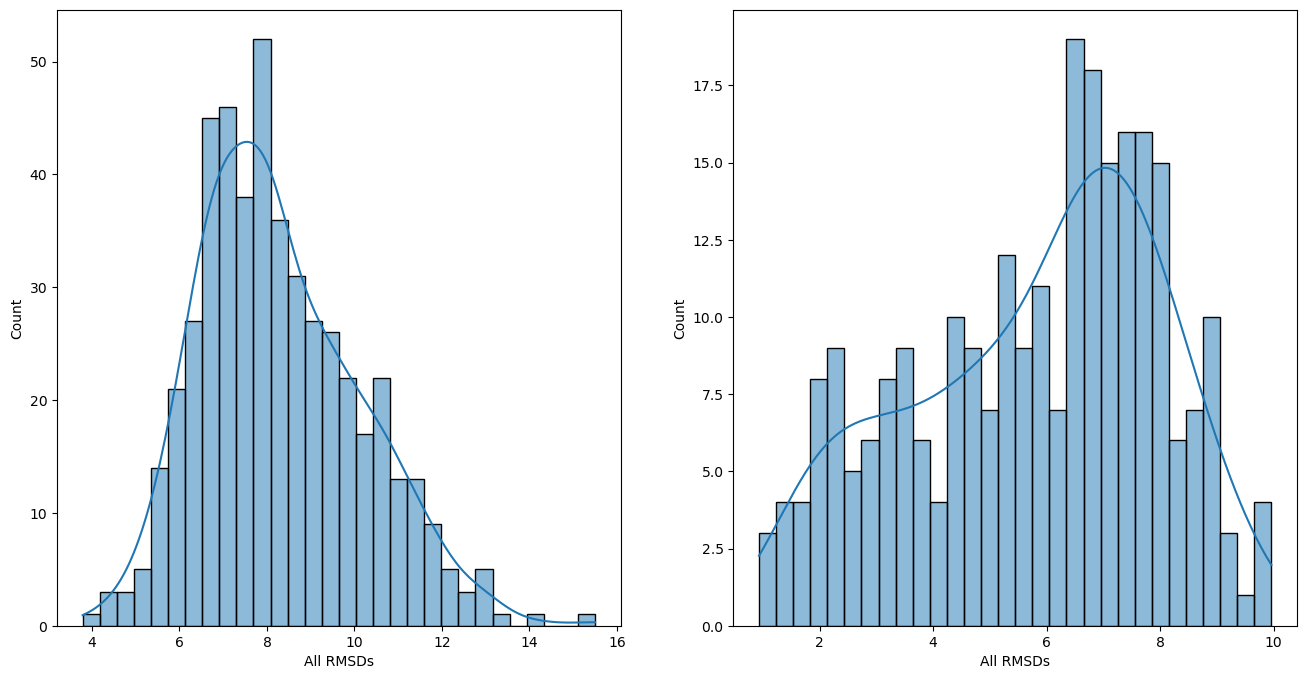

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns   


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.histplot(all_rmsds, bins=30, kde=True)
plt.xlabel("All RMSDs")

plt.subplot(1, 2, 2)
sns.histplot(all_rmsds_rd, bins=30, kde=True)
plt.xlabel("All RMSDs")
plt.show()

In [ ]:
for i, row in tqdm(merged.iterrows()):
    gt_mol = SDMolSupplier(row["conf_path"])[0]
    ginger_mol = SDMolSupplier(row["conf_path_ging"])[0]

    res = get_conformer_statistics(ginger_mol)
    posebusters_resuls.append(res['results'])
    rmsd_matrix = calculate_rmsd_matrix(gt_mol, ginger_mol)

    

In [49]:
m = Chem.SDMolSupplier("/auto/home/davit/3DMolGen/data/eval/output_censo_2d.sdf")[0]

AllChem.EmbedMultipleConfs(m, numConfs=10, randomSeed=42, pruneRmsThresh=0.5, maxAttempts=1000)


AllChem.MMFFOptimizeMoleculeConfs(
    m, 
    maxIters=500
)

m.GetNumConformers()

w = Chem.SDWriter("a.sdf")
w.write(m)
w.close()
Chem.SDMolSupplier("a.sdf")[0].GetNumConformers()

[13:36:10] Molecule does not have explicit Hs. Consider calling AddHs()
[13:36:10] Molecule does not have explicit Hs. Consider calling AddHs()


1